In [1]:
%pylab inline
import numpy as np
import geopandas as gp
import matplotlib.pyplot as pl
import pandas as pd
import sklearn.cluster
from sklearn import mixture
from PIL import Image
from scipy.misc import imread
from scipy.cluster.vq import kmeans2
import json
import os
import zipfile
s = json.load(open(os.getenv('PUI2015')+'/PUI2015_MMajumdar/pui.json'))
pl.rcParams.update(s)

Populating the interactive namespace from numpy and matplotlib


C:\Users\ManushiM\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\Users\ManushiM\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Data Wrangling

In [2]:

dataYears = ['94', '95', '96', '97', '98', '99', '00', '01', '02', '03', 
             '04', '05', '06', '07', '08', '09', '10', '11', '12', '13']

for year in dataYears:
    fname = 'zbp'+year+'totals.zip' 
    zf = zipfile.ZipFile(fname)
    try:
        temp = pd.read_csv(zf.open(fname.replace('.zip','.txt')))[['zip','est']]
    except KeyError:
        temp = pd.read_csv(zf.open(fname.replace('.zip','.txt')))[['ZIP','EST']]  
    temp.columns = [['zip','est'+year]]
    if(year == '94'):
        data = pd.DataFrame(temp)
    data = pd.merge(data,temp,on='zip')
data.head()

,zip,est94_x,est94_y,est95,est96,est97,est98,est99,est00,est01,...,est04,est05,est06,est07,est08,est09,est10,est11,est12,est13
0,1001,439,439,439,433,457,444,469,493,490,...,500,509,509,503,477,458,448,436,453,439
1,1002,450,450,467,487,500,490,558,563,587,...,584,589,582,596,584,571,570,558,572,572
2,1003,10,10,10,13,15,14,13,13,13,...,15,12,12,16,17,16,16,16,15,15
3,1004,47,47,48,47,41,31,35,48,37,...,43,31,30,20,18,18,21,19,16,16
4,1005,92,92,95,101,104,95,82,86,90,...,97,94,98,106,97,87,96,91,94,97


In [3]:
data.drop('est94_y', axis=1, inplace=True)
data = data.rename(columns={'est94_x':'est94'})
data.head()

,zip,est94,est95,est96,est97,est98,est99,est00,est01,est02,...,est04,est05,est06,est07,est08,est09,est10,est11,est12,est13
0,1001,439,439,433,457,444,469,493,490,490,...,500,509,509,503,477,458,448,436,453,439
1,1002,450,467,487,500,490,558,563,587,566,...,584,589,582,596,584,571,570,558,572,572
2,1003,10,10,13,15,14,13,13,13,15,...,15,12,12,16,17,16,16,16,15,15
3,1004,47,48,47,41,31,35,48,37,23,...,43,31,30,20,18,18,21,19,16,16
4,1005,92,95,101,104,95,82,86,90,94,...,97,94,98,106,97,87,96,91,94,97


In [4]:
data.info()
print len(data['zip'].unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35954 entries, 0 to 35953
Data columns (total 21 columns):
zip      35954 non-null int64
est94    35954 non-null int64
est95    35954 non-null int64
est96    35954 non-null int64
est97    35954 non-null int64
est98    35954 non-null int64
est99    35954 non-null int64
est00    35954 non-null int64
est01    35954 non-null int64
est02    35954 non-null int64
est03    35954 non-null int64
est04    35954 non-null int64
est05    35954 non-null int64
est06    35954 non-null int64
est07    35954 non-null int64
est08    35954 non-null int64
est09    35954 non-null int64
est10    35954 non-null int64
est11    35954 non-null int64
est12    35954 non-null int64
est13    35954 non-null int64
dtypes: int64(21)
memory usage: 6.0 MB
35953


In [5]:
NYC_zip = gp.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
NYC_zip['postalCode'] = NYC_zip['postalCode'].astype(int64)
NYC_zip.info()
NYC_zipCodes = pd.DataFrame(NYC_zip['postalCode']).drop_duplicates()
print NYC_zipCodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 262 entries, 0 to 261
Data columns (total 12 columns):
@id               262 non-null object
BLDGpostalCode    262 non-null int64
CTY_FIPS          262 non-null object
OBJECTID          262 non-null int64
PO_NAME           262 non-null object
STATE             262 non-null object
ST_FIPS           262 non-null object
Shape_Area        262 non-null float64
Shape_Leng        262 non-null float64
borough           262 non-null object
geometry          262 non-null object
postalCode        262 non-null int64
dtypes: float64(2), int64(3), object(7)
memory usage: 26.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 0 to 261
Data columns (total 1 columns):
postalCode    247 non-null int64
dtypes: int64(1)
memory usage: 3.9 KB
None


In [6]:
finalData = pd.merge(data, NYC_zipCodes, left_on = 'zip', right_on = 'postalCode')
finalData.info()
print len(finalData['zip'].unique())
print finalData.head()

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 230 entries, 0 to 229
Data columns (total 22 columns):
zip           230 non-null int64
est94         230 non-null int64
est95         230 non-null int64
est96         230 non-null int64
est97         230 non-null int64
est98         230 non-null int64
est99         230 non-null int64
est00         230 non-null int64
est01         230 non-null int64
est02         230 non-null int64
est03         230 non-null int64
est04         230 non-null int64
est05         230 non-null int64
est06         230 non-null int64
est07         230 non-null int64
est08         230 non-null int64
est09         230 non-null int64
est10         230 non-null int64
est11         230 non-null int64
est12         230 non-null int64
est13         230 non-null int64
postalCode    230 non-null int64
dtypes: int64(22)
memory usage: 41.3

In [7]:
finalData.drop('postalCode', axis=1, inplace=True)
finalData.index = finalData.zip
finalData = finalData[finalData.columns[1:21]]

In [8]:
finalData = (finalData - finalData.mean())/finalData.std()
finalData.head()

,est94,est95,est96,est97,est98,est99,est00,est01,est02,est03,est04,est05,est06,est07,est08,est09,est10,est11,est12,est13
zip,,,,,,,,,,,,,,,,,,,,
10001,5.304774,5.239058,5.207499,5.147116,5.172789,5.157744,5.122902,4.998208,5.111174,5.055590,5.129405,5.110101,5.157372,5.328369,5.276719,5.207516,5.138689,5.098606,5.042905,5.012079
10002,0.839114,0.835064,0.907626,0.978188,0.922860,0.985632,1.109648,1.315042,1.125201,1.225034,1.295671,1.405279,1.396396,1.411745,1.416194,1.500523,1.567149,1.584571,1.590165,1.588062
10003,2.099603,2.137289,2.156891,2.191709,2.255060,2.261254,2.229219,2.154756,2.227234,2.290259,2.270214,2.353489,2.369048,2.510075,2.530506,2.583980,2.581633,2.600099,2.606389,2.618064
10004,0.266242,0.254162,0.252137,0.262815,0.253522,0.295142,0.326904,0.287403,0.293972,0.284167,0.286919,0.267426,0.302857,0.352871,0.354368,0.358147,0.362194,0.356492,0.370697,0.382265
10005,0.232846,0.241624,0.321356,0.306913,0.329601,0.302436,0.321330,0.288989,0.286608,0.241623,0.241573,0.230618,0.261502,0.274764,0.285733,0.272223,0.254287,0.272611,0.234394,0.236035


### K Means Clustering

In [9]:
finalDataArray = finalData.as_matrix()
np.shape(finalDataArray)

(230L, 20L)

In [10]:
zips=[]
for i in range(230):
    new = finalDataArray[i][1:]
    zips.append(finalDataArray[i][0])
    array_mean = np.mean(new)
    array_std = np.std(new)
    for i in range(len(new)):
        new[i] = (new[i]-array_mean)/array_std
    finalDataArray[i][1:] = new

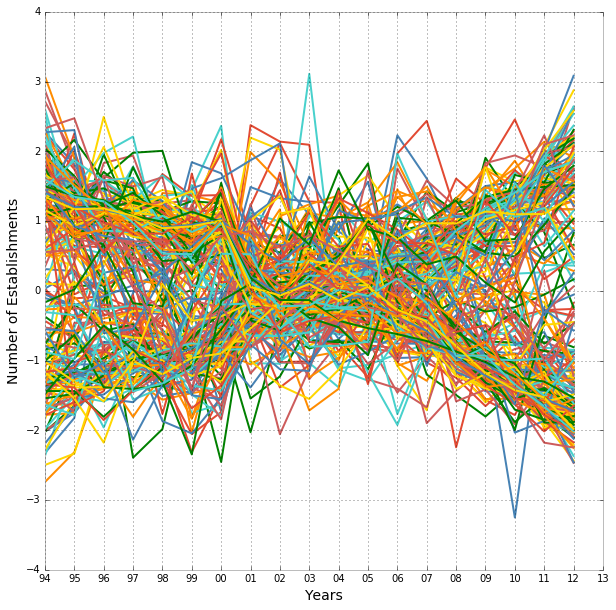

In [11]:
plt.figure(figsize=(10, 10), dpi=200)
#Make a list to have all data but not zip code
s = []
for i in range(230):
    ax = plt.plot(range(19), finalDataArray[i][1:])
    s.append(finalDataArray[i][1:])
    
plt.ylabel('Number of Establishments', fontsize = 14)
plt.xlabel('Years', fontsize = 14)
plt.xticks(range(20), dataYears);
s=np.array(s)

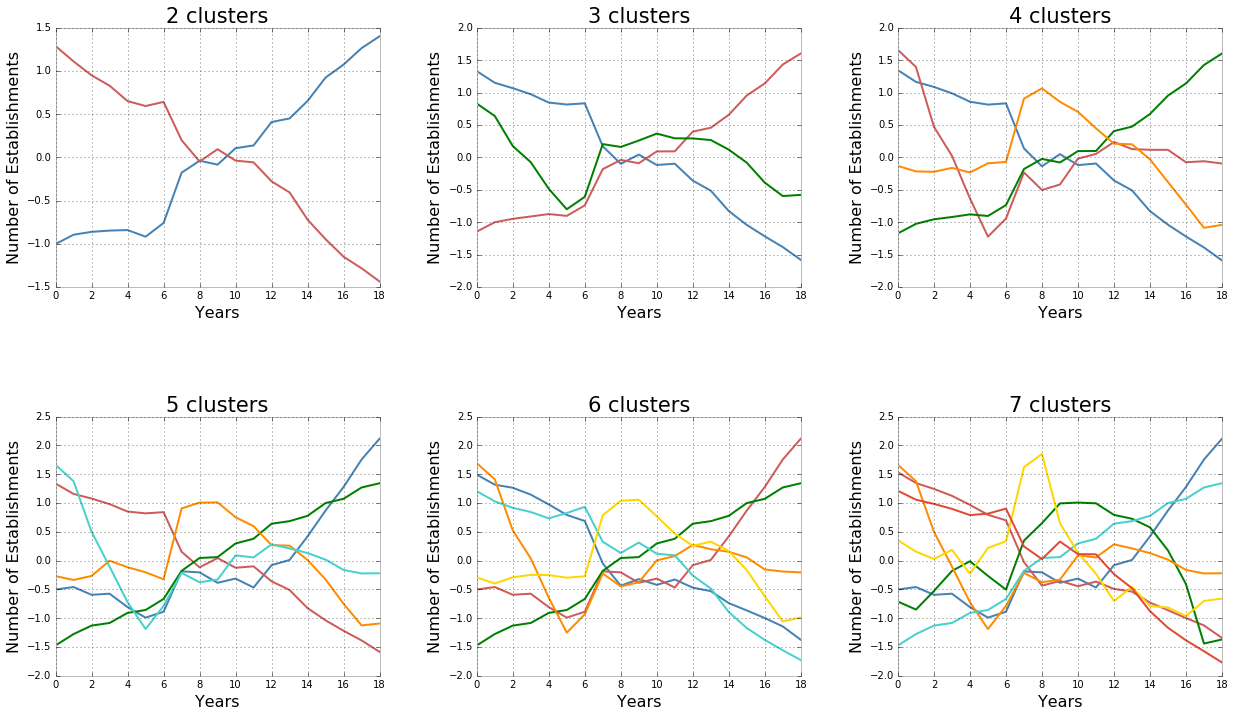

In [12]:
from sklearn.cluster import k_means

p=1
n=1
plt.figure(figsize=(18, 18), dpi=200)
for i in range(6):
    n = i+2
    result = k_means(s, n_clusters = n)
    plt.subplot(2, 3, p)
    p+=1
    plt.plot(range(19), transpose(result[0]))
    plt.title(str(n)+' clusters', fontsize = 21)
    plt.ylabel('Number of Establishments', fontsize = 16)
    plt.xlabel('Years', fontsize = 16)
plt.subplots_adjust(wspace=.3, hspace=0.5, left=0, right=0.9, top=0.5, bottom=0)

### We will continue ahead with numberOfClusters = 5

In [13]:
#Making a dataframe to use for mapping  
with_zip=pd.DataFrame()
with_zip['zip']=zips

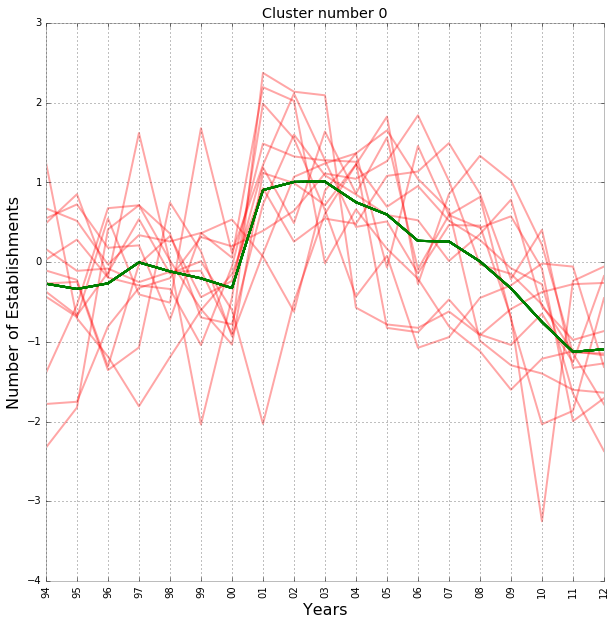

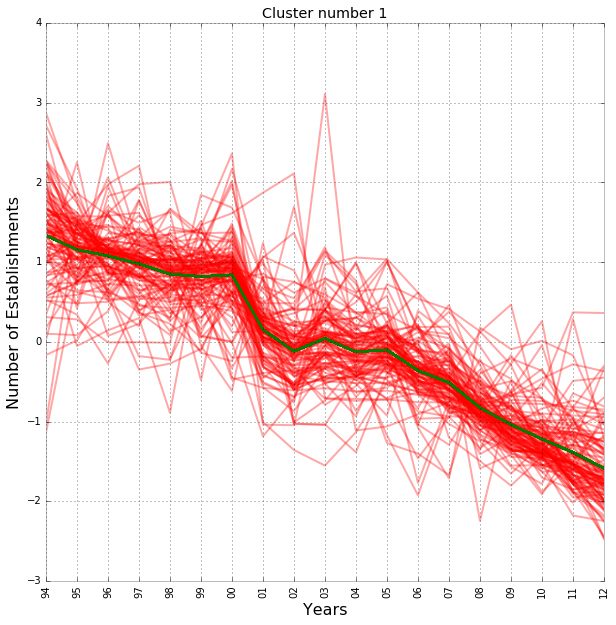

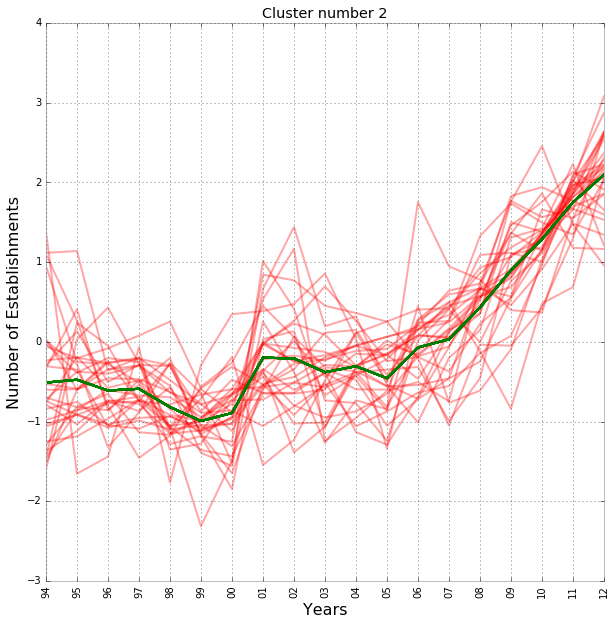

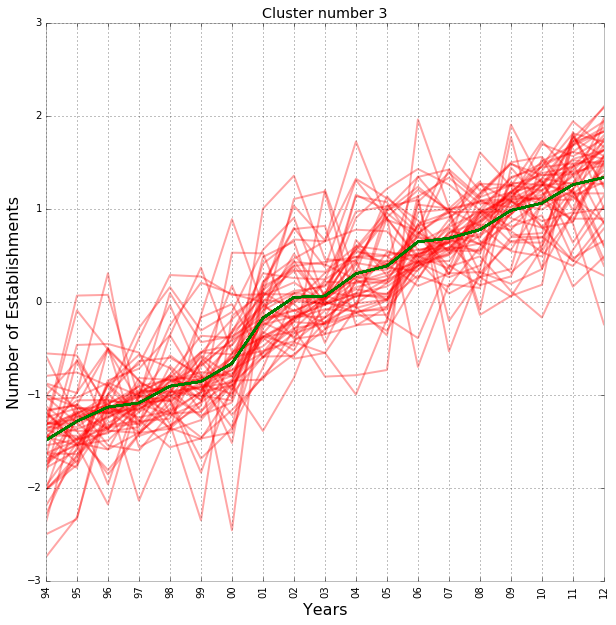

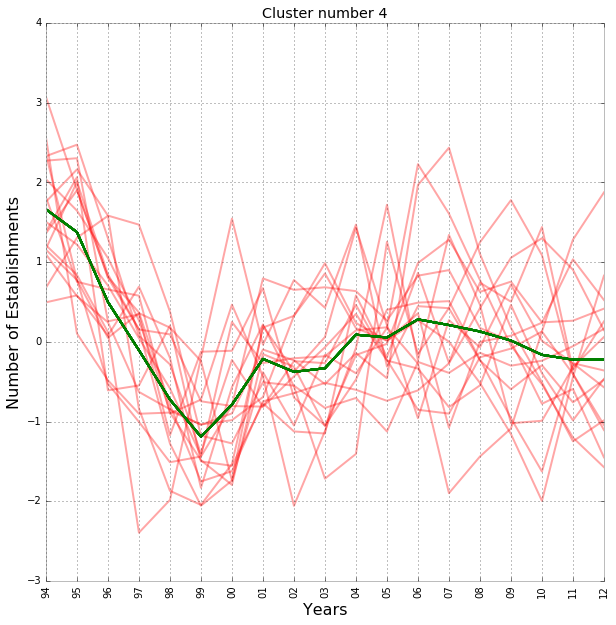

In [14]:
est = k_means(s,n_clusters=5)
with_zip['cluster'] = est[1]
for m in range(5):
    i = 0
    fig0 = plt.figure(figsize=(10,10));
    ax0 = fig0.add_subplot(1,1,1);
    for j in est[1]:
        if j==m:
            ax0.plot(range(19),s[i],c='r', alpha = 0.35)
            ax0.plot(range(19),est[0][j],c='g')
            plt.title('Cluster number ' + str(m))
            plt.ylabel('Number of Establishments', fontsize = 16)
            plt.xlabel('Years', fontsize = 16)
            plt.xticks(range(19), dataYears, rotation = 90);
        i = i+1      

### Second Clustering Algorithm : Agglomerative Clustering

In [15]:
from sklearn.cluster import AgglomerativeClustering
agc = AgglomerativeClustering(n_clusters=5, compute_full_tree=True).fit(s)
with_zip['cluster2']=agc.labels_

### Plotting it on the map of New York City

In [16]:
#Putting the clusters into a geodataframe
clusters = NYC_zip.join(with_zip,rsuffix='zip',how='inner')

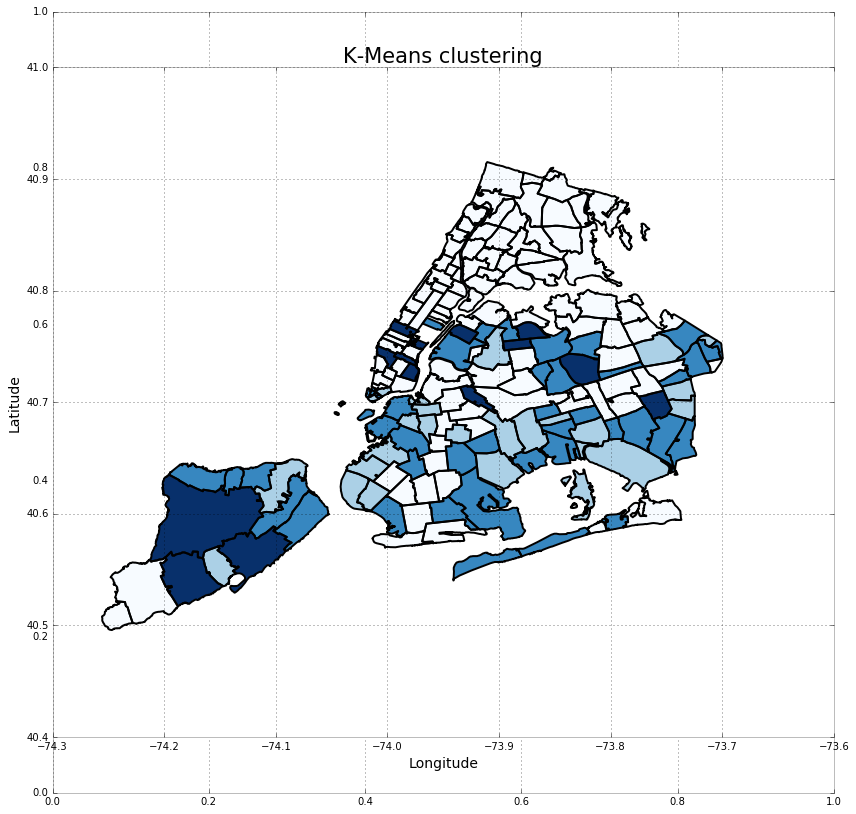

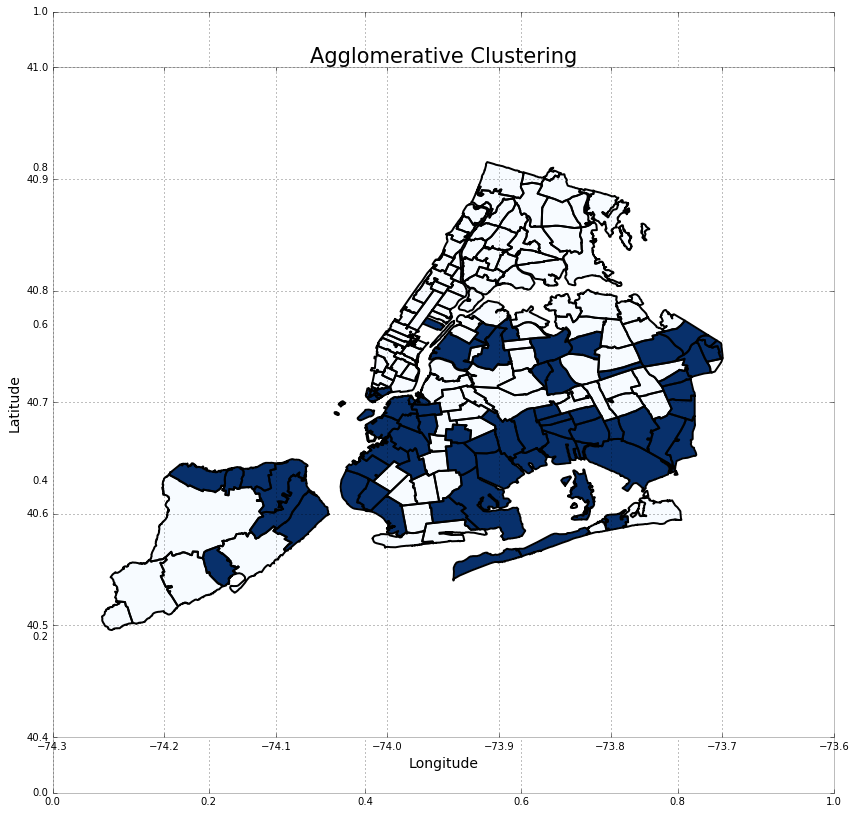

In [17]:
f, ax = plt.subplots(1, figsize=(14,14))
clusters.plot(column='cluster', scheme='QUANTILES', alpha=1, colormap='Blues')
plt.title('K-Means clustering', fontsize = 21)
plt.xlabel('Longitude', fontsize =14)
plt.ylabel('Latitude', fontsize = 14)
f2, ax2 = plt.subplots(1, figsize=(14,14))
clusters.plot(column='cluster2', scheme='QUANTILES', alpha=1, colormap='Blues')
plt.title('Agglomerative Clustering',fontsize = 21)
plt.xlabel('Longitude', fontsize =14)
plt.ylabel('Latitude', fontsize = 14)

## Interpretation and Comparison of the 2 algorithms:

1. Both the algorithms highlight some common areas in Brooklyn, Queens and Staten Island.

2. K-means shows gradually occuring changes in most of MAnhattan and few areas of Bronx, but rapid changes over the years in Brooklyn, Queens and Staten Island.

3. There is no particular way of saying that one algorithm is better than the other